# 04 Data Processing and Factor Computation

This notebook loads the processed dependency size data, calculates linguistic factors (such as HCS and Diagonal factors), and generates analysis tables.

**Output**:
- `data/hcs_factors.csv`: Computed HCS factors for all languages.
- `data/verb_centered_table.txt`: Verb-centered constituent size table.

In [1]:
# !pip install openpyxl

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
from importlib import reload

# Custom modules
import data_utils
import compute_factors
import verb_centered_analysis

# Reload to ensure latest changes are picked up
reload(compute_factors)
reload(verb_centered_analysis)

<module 'verb_centered_analysis' from '/bigstorage/kim/typometrics/dataanalysis/verb_centered_analysis.py'>

In [3]:
# Configuration
DATA_DIR = "data"
OUTPUT_DIR = "data"

## 1. Load Data

In [4]:
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))
langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']

print(f"Loaded metadata for {len(langNames)} languages")

Loaded metadata from data/metadata.pkl
Loaded metadata for 186 languages


In [5]:
# Load average sizes
with open(os.path.join(DATA_DIR, 'all_langs_average_sizes.pkl'), 'rb') as f:
    all_langs_average_sizes_filtered = pickle.load(f)

# Save filtered data for notebook 05 (if needed by downstream)
with open(os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl'), 'wb') as f:
    pickle.dump(all_langs_average_sizes_filtered, f)

print(f"Loaded average sizes for {len(all_langs_average_sizes_filtered)} languages")

Loaded average sizes for 185 languages


## 2. Compute HCS Factors

In [6]:
hcs_df = compute_factors.compute_hcs_factors(
    all_langs_average_sizes_filtered, 
    langNames, 
    langnameGroup
)

print(f"Computed HCS factors for {len(hcs_df)} languages")
print(hcs_df.head())

Computed HCS factors for 170 languages
    language_code  language_name           group  right_1_totright_2  \
80             ko         Korean           Other            1.824906   
116           pad        Paumarí  South-American            2.139826   
146            tn         Tswana     Niger-Congo            2.213364   
137           ssp    SpanishSign   Indo-European            1.525921   
144           qte  TeluguEnglish       Dravidian            1.000000   

     right_2_totright_2  hcs_factor  
80             1.031262    0.565104  
116            1.414214    0.660901  
146            1.778279    0.803428  
137            1.389013    0.910278  
144            1.000000    1.000000  


In [7]:
hcs_path = os.path.join(OUTPUT_DIR, 'hcs_factors.csv')
hcs_df.to_csv(hcs_path, index=False)
print(f"Saved HCS factors to {hcs_path}")

Saved HCS factors to data/hcs_factors.csv


## 3. Helix tables (Verb-Centered Constituent Size Analysis)

Verb-Centered Constituent Size Analysis = a helix table with consituent size averages X per construction of dependents to the right and the left of the verb: 
      VXXXX
      VXXX
      VXX
      VX
     XV
    XXV
   XXXV
  XXXXV

This table shold come in multiple options:

1. Simple: just showing the average constituent size X per construction of dependents to the right and the left of the verb
2. Horizontal Growth: inbetween two Xs, the factor of growth going from left to right
3. Horizontal Growth: inbetween two Xs, the factor of growth going from right to left
4. Diagonal Growth added as an extra line: Going up right, the growth factor going between the last X of one to the next constructio, such as between the last X of VXXX to the last X of VXXXX etc.
5. The same as 4 but going down left.



In [8]:
# Verb-Centered Constituent Size Analysis
position_averages = verb_centered_analysis.compute_average_sizes_table(all_langs_average_sizes_filtered)
# Table saved in mass generation step below

## 4. Generate Helix Tables (Mass Generation)

Generate helix tables for all languages, families, and order types.

In [9]:
# ## OPTIONAL: Compute Disorder Percentages
# ## Uncomment to compute disorder statistics

# import compute_disorder
# from importlib import reload
# reload(compute_disorder)

# # Compute disorder statistics with granular stats if available
# import pickle

# # Load granular ordering stats
# ordering_stats = {}
# disorder_pct_path = 'data/sentence_disorder_percentages.pkl'
# if os.path.exists(disorder_pct_path):
#     with open(disorder_pct_path, 'rb') as f:
#         ordering_stats = pickle.load(f)
#     print(f"Loaded granular ordering stats for {len(ordering_stats)} languages")

# disorder_df, disorder_percentages = compute_disorder.compute_disorder_statistics(
#     all_langs_average_sizes_filtered,
#     langNames,
#     langnameGroup,
#     ordering_stats=ordering_stats
# )
# print(f"Computed disorder for {len(disorder_df)} languages")
# print("\nDisorder percentages by configuration:")
# for (side, tot), pct in sorted(disorder_percentages.items()):
#     if pct is not None:
#         print(f"  {side} tot={tot}: {pct:.1f}% disordered")

# print("\n", disorder_df.head())

In [25]:
import pandas as pd
import pickle
from importlib import reload
import verb_centered_analysis

# Reload the module to use the latest table formatting logic
reload(verb_centered_analysis)

OUTPUT_TABLE_DIR = os.path.join(DATA_DIR, 'tables')

print("--- Starting Mass Table Generation ---")

# 1. Load Average Sizes (should already be loaded from previous cells)
if 'all_langs_average_sizes_filtered' not in locals():
    avg_path = os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl')
    if os.path.exists(avg_path):
        with open(avg_path, 'rb') as f:
            all_langs_average_sizes_filtered = pickle.load(f)
        print("Loaded average sizes from disk.")
    else:
        print("ERROR: 'all_langs_average_sizes_filtered' not found. Run previous cells first.")

# 2. Load Ordering Statistics (optional - for ordering triples)
ordering_stats = {}
disorder_path = os.path.join(DATA_DIR, 'sentence_disorder_percentages.pkl')

if os.path.exists(disorder_path):
    with open(disorder_path, 'rb') as f:
        loaded_data = pickle.load(f)
        
    # Check if the data is in the new format (triplet counts)
    sample_lang = next(iter(loaded_data))
    sample_keys = list(loaded_data[sample_lang].keys()) if loaded_data[sample_lang] else []
    
    if sample_keys and len(sample_keys[0]) == 3:
        print("Loaded Ordering Stats (Triplets) successfully.")
        ordering_stats = loaded_data
    else:
        print("WARNING: Loaded data seems to be in OLD format. Triples cannot be shown.")
else:
    print(f"WARNING: {disorder_path} not found. Tables will be generated without triples.")

# 3. Load VO/OV Data (optional - for order-based tables)
vo_data = {}
vo_path = os.path.join(DATA_DIR, 'vo_vs_hi_scores.csv')
if os.path.exists(vo_path):
    vo_df = pd.read_csv(vo_path)
    for _, row in vo_df.iterrows():
        vo_data[row['language_code']] = row.to_dict()
    print("Loaded VO/OV classifications.")

# 4. Generate Tables AND Extract Disorder Metrics
# This will generate: Global, Individual, Family-based, and Order-based tables.
# Also extracts disorder extreme aggregate percentages for each language
disorder_df = verb_centered_analysis.generate_mass_tables(
    all_langs_average_sizes_filtered,
    ordering_stats,
    metadata,  # Ensure metadata is loaded (from Cell 6)
    vo_data=vo_data,
    output_dir=OUTPUT_TABLE_DIR,
    arrow_direction='left_to_right',
    extract_disorder_metrics=True
)

print(f"--- Completed. Tables saved to {OUTPUT_TABLE_DIR}/ ---")

# Save disorder metrics if extracted
if disorder_df is not None and len(disorder_df) > 0:
    disorder_csv_path = os.path.join(DATA_DIR, 'disorder_extreme_aggregates.csv')
    disorder_df.to_csv(disorder_csv_path, index=False)
    print(f"\nExtracted and saved disorder metrics for {len(disorder_df)} languages to {disorder_csv_path}")
    print("\nSample disorder metrics:")
    print(disorder_df.head(10))


--- Starting Mass Table Generation ---
Loaded Ordering Stats (Triplets) successfully.
Loaded VO/OV classifications.
Generating tables in data/tables...
Mass table generation complete. Output in: data/tables
--- Completed. Tables saved to data/tables/ ---

Extracted and saved disorder metrics for 185 languages to data/disorder_extreme_aggregates.csv

Sample disorder metrics:
  language_code  language_name  right_extreme_disorder  left_extreme_disorder  \
0           abq          Abaza               25.000000              21.052632   
1            ab         Abkhaz                0.000000              17.148362   
2            af      Afrikaans               19.103314              45.288501   
3           aqz        Akuntsu                0.000000               3.846154   
4            sq       Albanian               10.828025              14.583333   
5           gsw    SwissGerman                9.056604              36.990291   
6            am        Amharic                3.217158  

## 5. Conll Configuration Example Creation

Generate interactive HTML visualizations of verb configurations from examples collected during data extraction.

**Note**: Examples are automatically collected by `run_data_extraction.py` using the same constraints as constituent size computation (same dependency relations, bastard inclusion, etc.). This ensures consistency and avoids duplicate CoNLL file parsing.

In [36]:
# Generate HTML visualizations from configuration examples collected during data extraction
# Examples are automatically collected in run_data_extraction.py using the same constraints
# as constituent size computation (same dependency relations, bastard inclusion, etc.)

import generate_html_examples
from importlib import reload
reload(generate_html_examples)

print("Generating HTML visualizations from saved configuration examples...")
print("="*60)

# Check if examples have been collected
examples_path = os.path.join(DATA_DIR, 'all_config_examples.pkl')
if not os.path.exists(examples_path):
    print(f"ERROR: Configuration examples not found at {examples_path}")
    print("\nPlease run data extraction first:")
    print("  python3 run_data_extraction.py")
    print("\nThis will collect examples during the main processing pipeline.")
else:
    # Generate HTML from saved examples
    output_dir = 'html_examples'
    generate_html_examples.generate_all_html(
        data_dir=DATA_DIR,
        output_dir=output_dir
    )
    
    print(f"\n{'='*60}")
    print(f"Configuration Examples Generated Successfully!")
    print(f"{'='*60}")
    print(f"Output directory: {output_dir}/")
    print(f"Open {output_dir}/index.html to browse examples")
    print(f"\nFeatures:")
    print(f"  • Interactive dependency trees with reactive-dep-tree")
    print(f"  • Verbs highlighted in red, dependents in green")
    print(f"  • Organized by language with 3-column layout")
    print(f"  • Same constraints as constituent size computation")
    print(f"{'='*60}")

Generating HTML visualizations from saved configuration examples...
Loading configuration examples...
Loading metadata...
Generating HTML for 185 languages...


Generating HTML files: 100%|██████████| 185/185 [00:08<00:00, 22.43it/s]


Generating index...
Generated index at html_examples/index.html
Done! HTML files saved to html_examples/

Configuration Examples Generated Successfully!
Output directory: html_examples/
Open html_examples/index.html to browse examples

Features:
  • Interactive dependency trees with reactive-dep-tree
  • Verbs highlighted in red, dependents in green
  • Organized by language with 3-column layout
  • Same constraints as constituent size computation


In [34]:
# Test updated table with all fixes
import importlib
import sys

# Reload all verb-centered modules
if 'verb_centered_model' in sys.modules:
    importlib.reload(sys.modules['verb_centered_model'])
if 'verb_centered_computations' in sys.modules:
    importlib.reload(sys.modules['verb_centered_computations'])
if 'verb_centered_layout' in sys.modules:
    importlib.reload(sys.modules['verb_centered_layout'])
if 'verb_centered_builder' in sys.modules:
    importlib.reload(sys.modules['verb_centered_builder'])
if 'verb_centered_formatters' in sys.modules:
    importlib.reload(sys.modules['verb_centered_formatters'])
if 'verb_centered_analysis' in sys.modules:
    importlib.reload(sys.modules['verb_centered_analysis'])

from verb_centered_analysis import create_verb_centered_table
from verb_centered_model import TableConfig
from verb_centered_formatters import TextTableFormatter

config_debug = TableConfig(
    show_horizontal_factors=True,
    show_diagonal_factors=True,
    show_ordering_triples=True,
    show_row_averages=True,
    show_marginal_means=True,
    arrow_direction='left_to_right'
)

# For testing, we need language-specific data
# Get English data if available
test_lang = 'en'  # Try different language codes
english_position_avg = None
english_ordering = None

for lang_code in all_langs_average_sizes_filtered.keys():
    if lang_code.startswith('en'):
        english_position_avg = all_langs_average_sizes_filtered[lang_code]
        english_ordering = ordering_stats.get(lang_code, {})
        print(f"Using language: {lang_code}")
        break

# Fallback to global if no English found
if english_position_avg is None:
    print("No English data found, using global averages (no ordering triples)")
    english_position_avg = position_averages
    english_ordering = None

# Create table structure
table_struct = create_verb_centered_table(
    position_averages=english_position_avg,
    ordering_stats=english_ordering,
    hcs_row=None,
    config=config_debug,
    output_format='struct'
)

# Format as text
formatter = TextTableFormatter(table_struct)
table_txt = formatter.format()

# Print only lower half to check
lines = table_txt.split('\n')
print('\n'.join(lines[10:]))  # Skip upper half to focus on lower half

Using language: en
Diag R2-1                                                                                                                     ×1.11↗                                                                                 
R tot=1                                                                                                  V        3.349                                                                                  [GM: 1.830 | N=72090]
------------------------------------------------------------------------------------------------------------------------
X V X                                                                                       1.258   ×2.80→ (<74=20>6)   3.519                                                                                           
------------------------------------------------------------------------------------------------------------------------
L tot=1                                                                              

In [28]:
# Check ordering_stats for English
if 'en_ewt' in ordering_stats:
    print("English ordering stats found:")
    for key, value in sorted(ordering_stats['en_ewt'].items()):
        print(f"  {key}: {value}")
else:
    print("No English ordering stats found")
    print(f"Available languages: {list(ordering_stats.keys())[:5]}")

No English ordering stats found
Available languages: ['abq', 'ab', 'af', 'aqz', 'sq']


In [29]:
# Check what position_averages contains
print("position_averages type:", type(position_averages))
if isinstance(position_averages, dict):
    print("First few keys:", list(position_averages.keys())[:10])

position_averages type: <class 'dict'>
First few keys: ['left_1', 'left_1_totleft_1', 'average_totleft_1', 'left_2', 'left_2_totleft_2', 'left_1_totleft_2', 'average_totleft_2', 'right_1', 'right_1_totright_1', 'average_totright_1']


In [30]:
# Print full table to see both aggregate rows
print(table_txt)

Row                         L4                    L3                    L2                    L1         V          R1                    R2                    R3                    R4                 [GM | N | Slope]
M Vert Right                                                                                                      2.032                 2.765                 3.698                 5.257                         
M Diag Right                                                                                                                             1.99       ×1.33↗        2.33       ×1.31↗        4.17       ×1.16↗               
Agg R Last→                                                                                                                                                                                              [(<68.4=16.4>15.2) N=33542]
------------------------------------------------------------------------------------------------------------------------
R

In [31]:
# Disorder metrics already extracted in previous cell during mass table generation
# Check if disorder_df exists and display summary
if 'disorder_df' in locals() and disorder_df is not None:
    print(f"Disorder metrics available for {len(disorder_df)} languages")
    print(f"Right extreme disorder range: {disorder_df['right_extreme_disorder'].min():.1f}% - {disorder_df['right_extreme_disorder'].max():.1f}%")
    print(f"Left extreme disorder range: {disorder_df['left_extreme_disorder'].min():.1f}% - {disorder_df['left_extreme_disorder'].max():.1f}%")
else:
    print("No disorder metrics available. Run the mass table generation cell first.")

Disorder metrics available for 185 languages
Right extreme disorder range: 0.0% - 81.0%
Left extreme disorder range: 0.0% - 59.5%


Generating all disorder and diagonal factor plots...
Merged data: 185 languages with disorder and VO data

1. Plotting Right Extreme Disorder vs VO (N=171)...


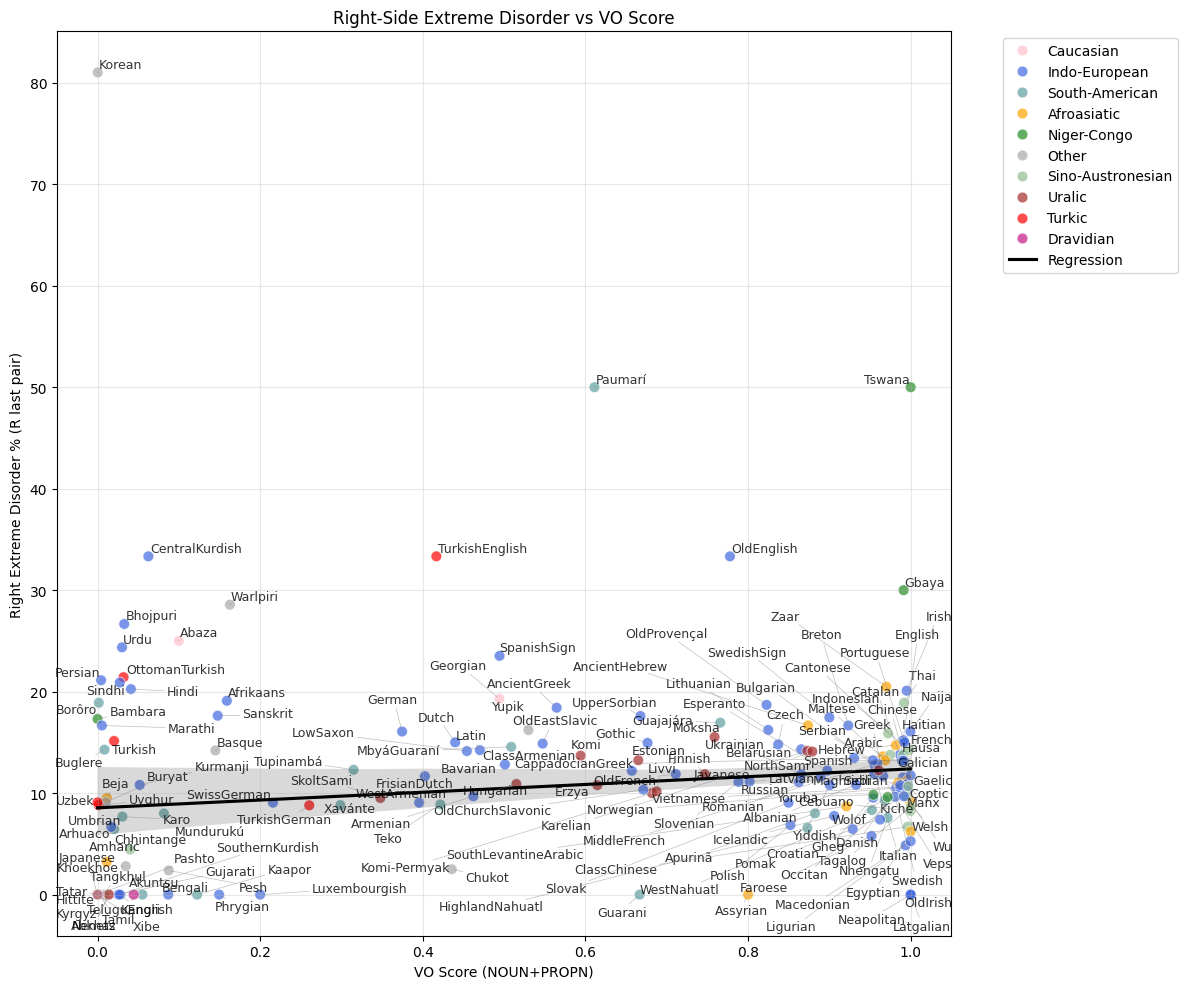

   Saved to plots/right_extreme_disorder_vs_vo.png

2. Plotting Left Extreme Disorder vs VO (N=185)...


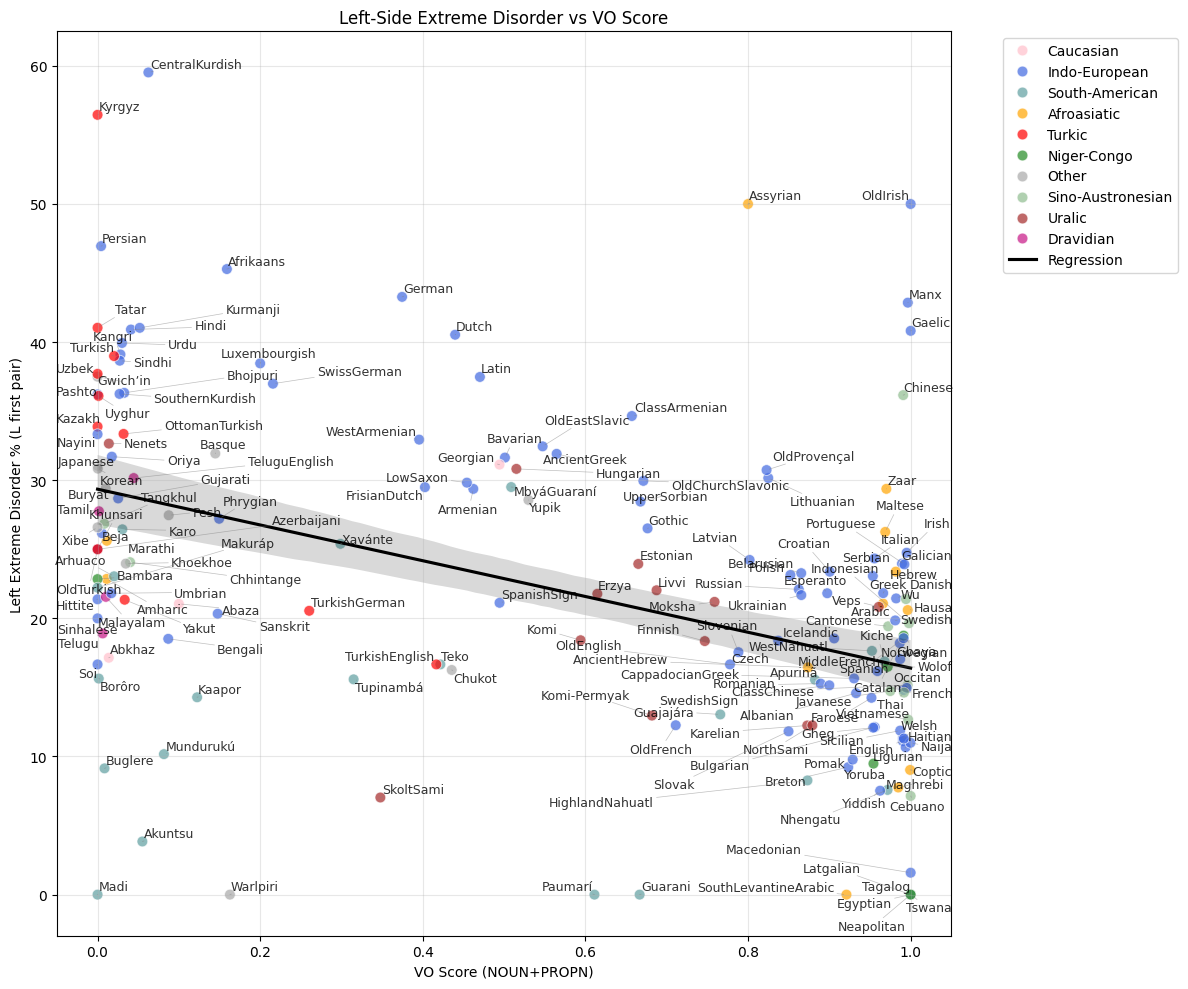

   Saved to plots/left_extreme_disorder_vs_vo.png

3. Plotting Right Extreme Diagonal Factor vs VO (N=170)...


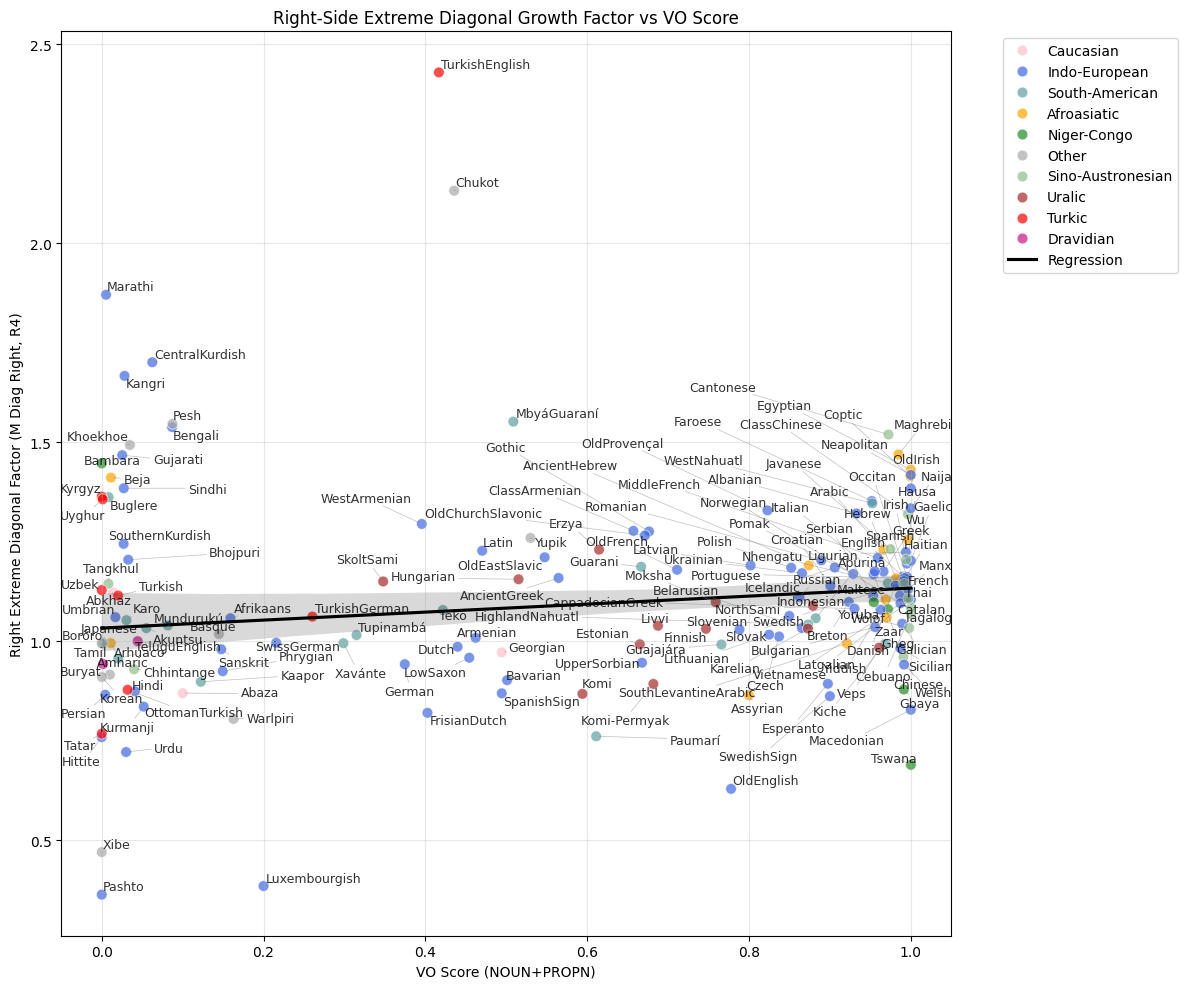

   Saved to plots/right_extreme_diag_factor_vs_vo.png

4. Plotting Left Extreme Diagonal Factor vs VO (N=185)...


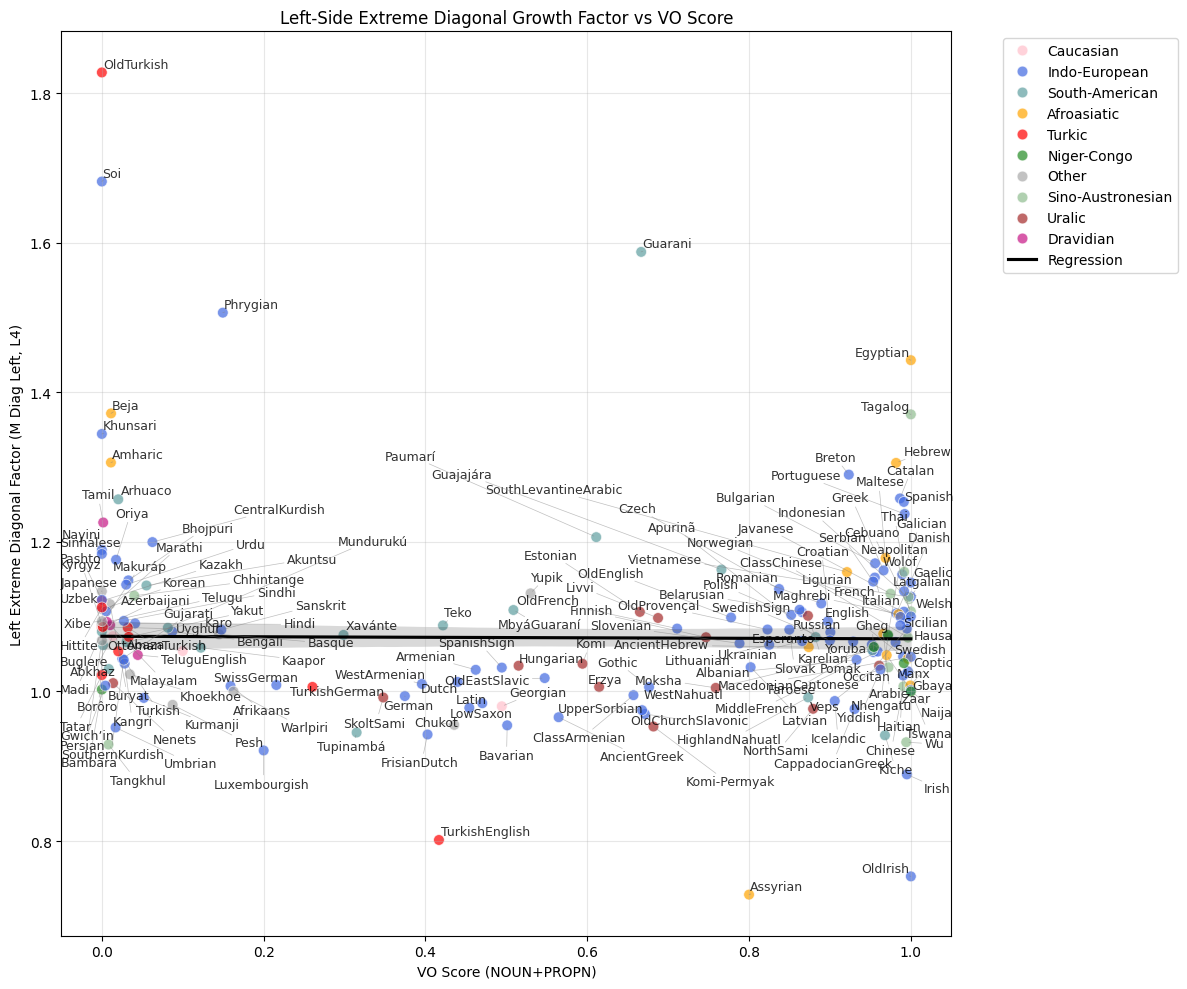

   Saved to plots/left_extreme_diag_factor_vs_vo.png

5. Plotting Right Diagonal Factor vs Right Disorder (N=170)...


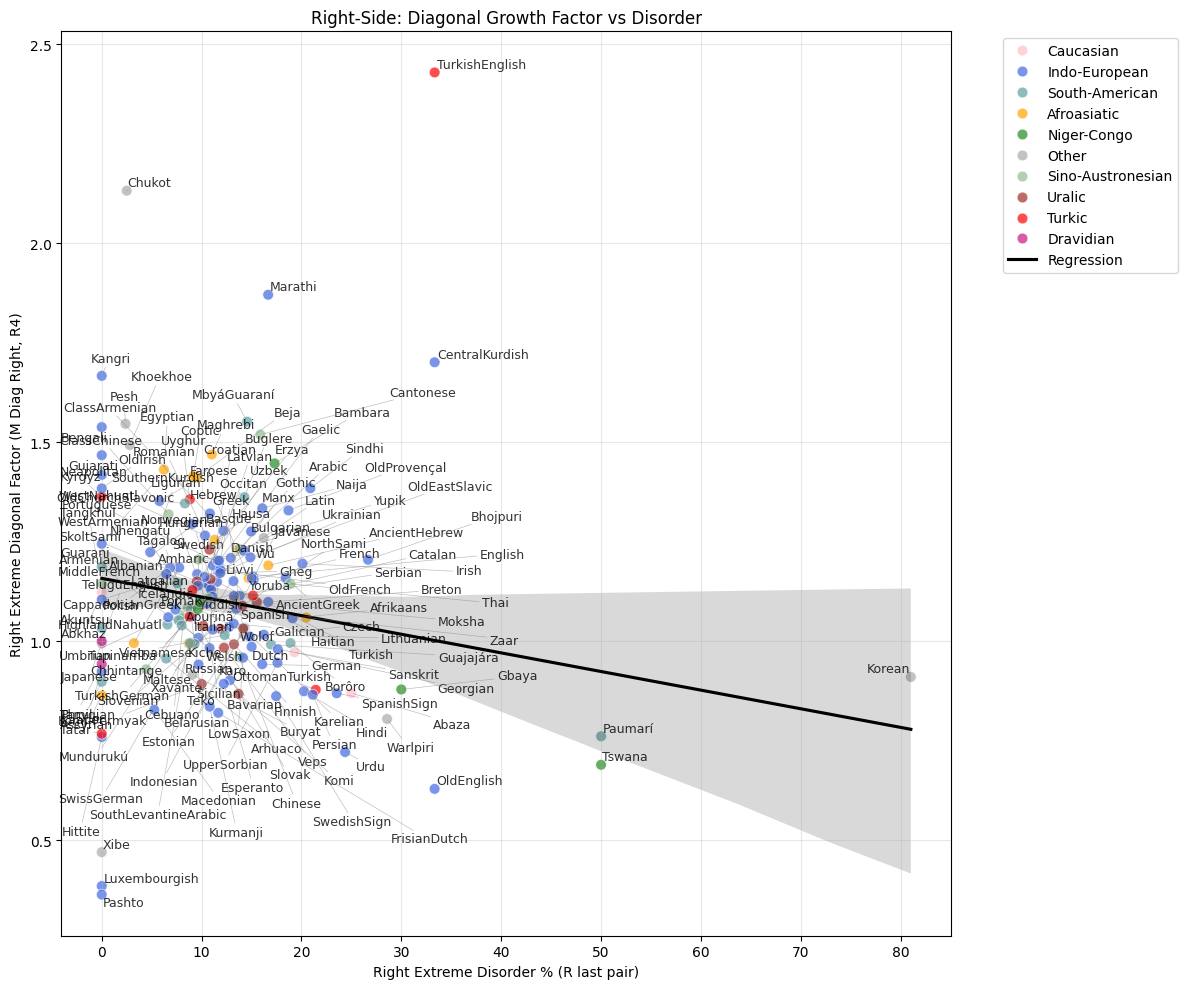

   Saved to plots/right_diag_factor_vs_disorder.png

6. Plotting Left Diagonal Factor vs Left Disorder (N=185)...


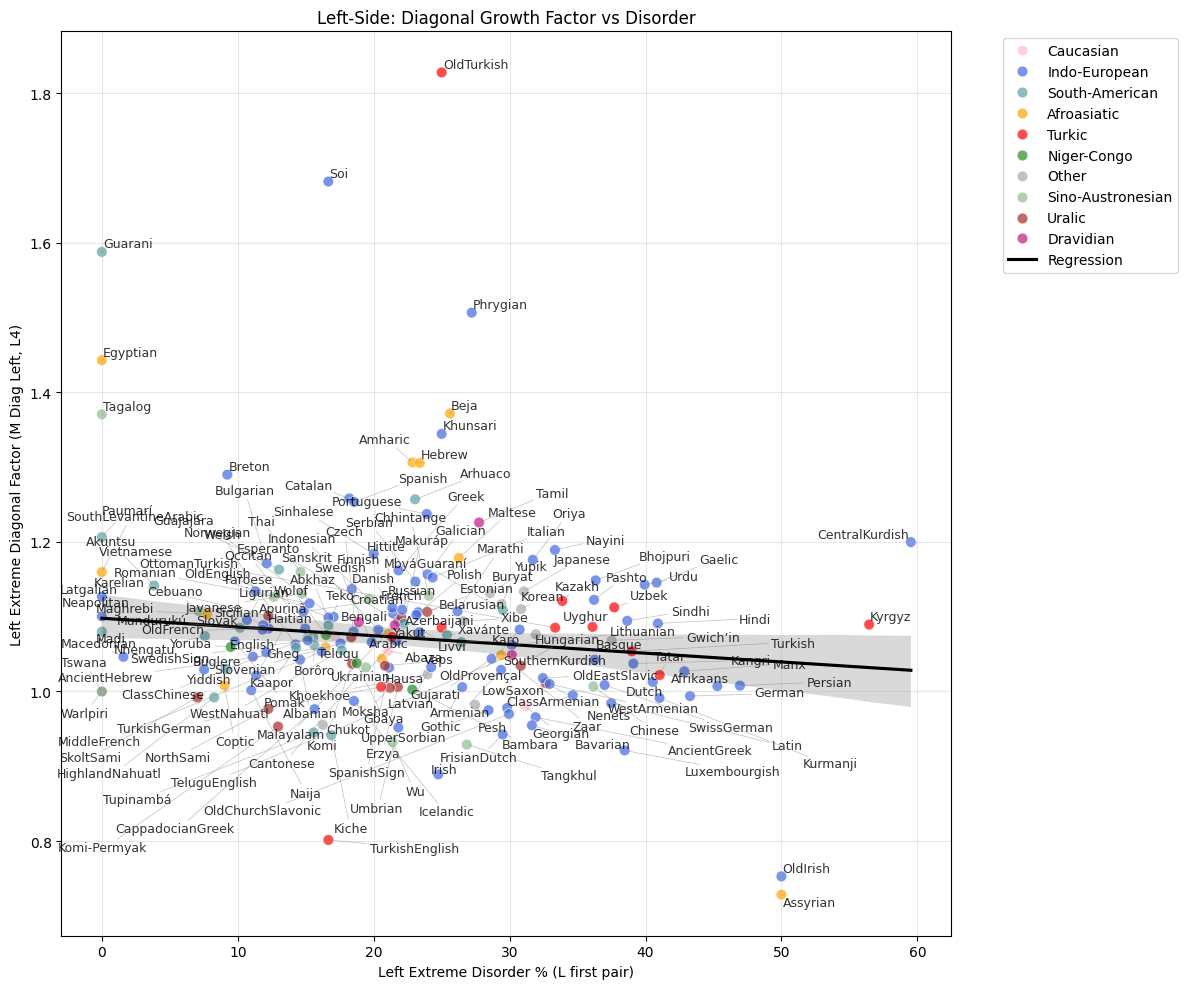

   Saved to plots/left_diag_factor_vs_disorder.png

Successfully created 6 plots:
  ✓ plots/right_extreme_disorder_vs_vo.png
  ✓ plots/left_extreme_disorder_vs_vo.png
  ✓ plots/right_extreme_diag_factor_vs_vo.png
  ✓ plots/left_extreme_diag_factor_vs_vo.png
  ✓ plots/right_diag_factor_vs_disorder.png
  ✓ plots/left_diag_factor_vs_disorder.png


In [17]:
## Plot All Disorder Metrics and Diagonal Factors
# Create comprehensive scatter plots comparing:
# - Disorder percentages vs VO scores
# - Diagonal growth factors vs VO scores  
# - Diagonal factors vs disorder percentages (right and left)

import plotting
from importlib import reload
reload(plotting)

if 'disorder_df' in locals() and disorder_df is not None:
    print("Generating all disorder and diagonal factor plots...")
    
    saved_plots = plotting.plot_disorder_metrics_vs_vo(
        disorder_df=disorder_df,
        langnameGroup=langnameGroup,
        appearance_dict=metadata['appearance_dict'],
        data_dir=DATA_DIR,
        plots_dir='plots'
    )
    
    if saved_plots:
        print(f"\n{'='*60}")
        print(f"Successfully created {len(saved_plots)} plots:")
        for plot_path in saved_plots:
            print(f"  ✓ {plot_path}")
        print(f"{'='*60}")
    else:
        print("No plots were created. Check error messages above.")
else:
    print("Cannot create plots: disorder_df not available. Run the mass table generation cell first.")